In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import utils.add_features as af
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tcn import TCN, tcn_full_summary
from copy import deepcopy 
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [33]:
SPLIT_DATE           = '2022-05-29 00:00:00'
INTERPOLATION_METHOD = 'linear'
INTERPOLATION_ORDER  = 3
RESAMPLE_FREQ        = '5min'
MODEL_PATH           = './models/test5/best_model.keras'

#MODEL PARAMETERS
PATIENCE             = 10
EPOCHS               = 100
WINDOW_SIZE          = 864 #keep in mind that each data point is 5 minutes apart
BATCH_SIZE           = 64 
TIMESTEPS_AHEAD      = 36 #keep in mind that each data point is 5 minutes apart
SHUFFLE_BUFFER_SIZE  = 1000


In [34]:
DATA_PATHS = [
              './datasets/ambient_measurements/2022/temp.csv',
              './datasets/ambient_measurements/2022/hum.csv',
              './datasets/ambient_measurements/2022/pressure.csv',
             ]

datasets = [pd.read_csv(path, index_col=0, parse_dates=True) for path in DATA_PATHS]
datasets = [af.interpolate_and_resample(df, freq=RESAMPLE_FREQ) for df in datasets]

In [35]:
full_dataset = af.encode_date(af.join_data(datasets))
full_dataset = af.add_rolling_features(full_dataset,
                                       windows=['15min',],
                                       variables=['temp_level', 'hum_level', 'pressure_level'],
                                       features=['mean', 'std', 'min', 'max']).bfill()

#normalizing the dataset
scaler = StandardScaler()
full_dataset = pd.DataFrame(scaler.fit_transform(full_dataset), columns=full_dataset.columns, index=full_dataset.index)
full_dataset.shape

(9709, 19)

In [36]:
full_dataset.head()

,temp_level,hum_level,pressure_level,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,temp_level_15min_mean,temp_level_15min_std,temp_level_15min_min,temp_level_15min_max,hum_level_15min_mean,hum_level_15min_std,hum_level_15min_min,hum_level_15min_max,pressure_level_15min_mean,pressure_level_15min_std,pressure_level_15min_min,pressure_level_15min_max
time,,,,,,,,,,,,,,,,,,,
2022-05-09 21:20:00,0.173259,0.506183,0.944813,-0.762989,1.125459,1.628837,1.998413,0.174705,-0.429291,0.250855,0.104926,0.507102,-0.400164,0.539695,0.473057,0.958150,-0.406172,1.038984,0.860054
2022-05-09 21:25:00,0.156787,0.523447,0.969605,-0.762989,1.125459,1.628837,1.998413,0.166396,-0.429291,0.233760,0.104926,0.515749,-0.400164,0.539695,0.490412,0.970723,-0.406172,1.038984,0.884895
2022-05-09 21:30:00,0.132080,0.534071,0.911757,-0.762989,1.125459,1.628837,1.998413,0.155317,-0.366408,0.208118,0.104926,0.522180,-0.370742,0.539695,0.501093,0.955356,-0.343480,1.005520,0.884895
2022-05-09 21:35:00,0.074430,0.544695,0.886965,-0.762989,1.125459,1.628837,1.998413,0.122081,-0.217244,0.148287,0.088814,0.535040,-0.425110,0.556915,0.511774,0.935798,-0.270457,0.980422,0.884895
2022-05-09 21:40:00,0.025016,0.557975,0.767139,-0.762989,1.125459,1.628837,1.998413,0.077766,-0.138822,0.097004,0.064646,0.546571,-0.403802,0.567511,0.525124,0.867344,-0.079887,0.859114,0.826932


In [37]:
NFEATURES = 19

# split the data and generate the windowed datasets

In [38]:
# Split the data into training and testing sets
train = deepcopy(full_dataset[:SPLIT_DATE])
test = deepcopy(full_dataset[SPLIT_DATE:])

In [39]:
def windowed_dataset(fulldata: pd.DataFrame,
                     window_size: int,
                     batch_size: int,
                     shuffle_buffer: int,
                     timesteps_ahead: int = 12, 
                     shuffle: bool = True) -> tf.data.Dataset:

    """
    Generates dataset windows

    Args:
      fulldata (pd.DataFrame) - contains the values of the time series
      window_size (int)       - the number of time steps to average
      batch_size (int)        - the batch size
      timestep_ahead (int)    - the number of time steps to predict
      shuffle_buffer(int)     - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Convert the series to a numpy array
    series = fulldata.to_numpy()

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + timesteps_ahead, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + timesteps_ahead))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-timesteps_ahead], window[-timesteps_ahead:, 0]))

    # Shuffle the windows
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [40]:
train_dataset = windowed_dataset(train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD)
test_dataset = windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD, shuffle=False)

# Print properties of a single batch
for windows in train_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')
  #print(f'first element: {windows[1]}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (64, 864, 19)
shape of second element: (64, 36)


# first model trial 

In [41]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE, NFEATURES]),
    TCN(
        nb_filters=256,
        kernel_size=2,
        dilations=[1, 2, 4, 8, 16, 32],
        activation='tanh',
        use_skip_connections=True,
        return_sequences=False
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_2 (TCN)                 (None, 256)               1459712   
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 36)                9252      
                                                                 
Total params: 1468964 (5.60 MB)
Trainable params: 1468964 (5.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
loss = tf.losses.Huber() #tf.losses.MeanSquaredError()
model1.compile(loss = loss,
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')
# Callback to save the best model
best_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,    # The path where to save the model
    monitor='val_loss',          # The metric to monitor
    verbose=1,                   # Verbosity mode
    save_best_only=True,         # Save only the best model
    mode='min'                   # Minimize the monitored metric (val_loss)
)

# Train the model and save the history
history = model1.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping, best_model_checkpoint])

Epoch 1/100
     72/Unknown - 48s 616ms/step - loss: 0.2304 - mae: 0.5314 - mse: 0.5410
Epoch 1: val_loss improved from inf to 0.16582, saving model to ./models/test5/best_model.keras
72/72 [==============================] - 61s 800ms/step - loss: 0.2304 - mae: 0.5314 - mse: 0.5410 - val_loss: 0.1658 - val_mae: 0.4582 - val_mse: 0.3479
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 0.0848 - mae: 0.3166 - mse: 0.1722
Epoch 2: val_loss improved from 0.16582 to 0.14917, saving model to ./models/test5/best_model.keras
72/72 [==============================] - 58s 800ms/step - loss: 0.0848 - mae: 0.3166 - mse: 0.1722 - val_loss: 0.1492 - val_mae: 0.4341 - val_mse: 0.3086
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 0.0562 - mae: 0.2539 - mse: 0.1132
Epoch 3: val_loss improved from 0.14917 to 0.14626, saving model to ./models/test5/best_model.keras
72/72 [==============================] - 58s 799ms/step - loss: 0.0562 - mae: 0.2539 - mse: 0.1132 -

In [43]:
custom_objects = {'TCN': TCN}

# Load the best saved model
best_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)

# Evaluate the best model on the test dataset
test_loss, test_mae, test_mse = best_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}')

52/52 [==============================] - 13s 245ms/step - loss: 0.1257 - mae: 0.3963 - mse: 0.2581
Test Loss: 0.12565867602825165, Test MAE: 0.3963276445865631, Test MSE: 0.25805148482322693


2024-03-10 19:42:47.769667: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12935676869002818054


In [44]:
# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [47]:
def plot_random_predictions(model_baseline,
                            test_dataset,
                            N: int = 12,
                            COLS: int = 4) -> None:
    """
    Plots N random predictions from the model_baseline compared to expected values from the test_dataset.
    
    Parameters:
    - model_baseline: The model used for making predictions. It must have a .predict() method.
    - test_dataset: The dataset to test the model on, expected to yield tuples of (features, labels).
    - N: The number of random predictions to plot. Default is 12.
    - COLS: The number of columns in the subplot grid. Default is 4.
    
    Returns:
    None. Displays a matplotlib figure with the plots.
    """
    # Make predictions on the test dataset
    baseline_preds = model_baseline.predict(test_dataset)
    
    # Concatenate all expected labels from the test dataset
    expected = np.concatenate([y for x, y in test_dataset], axis=0)
    print(f'Expected shape: {expected.shape}')
    
    # Randomly select N predictions for plotting
    samples = np.random.randint(0, len(baseline_preds), N)
    
    # Create subplots
    _, subplots = plt.subplots(N//COLS, COLS, figsize=(15, 10))
    subplots = subplots.ravel()
    
    # Plot each selected sample's expected vs. predicted values
    for i, sample in enumerate(samples):
        
        xrange = np.arange(len(expected[sample]))
        # concatenate the inputs and expected values, but plot the 
        # inputs in a different color than the expected values
        ypred = expected[sample]
        ytrue = list(baseline_preds[sample])

        # reverse the normalization
        #ypred = scaler.inverse_transform(ypred.reshape(-1, 1)).ravel()
        #ytrue = scaler.inverse_transform(np.array(ytrue).reshape(-1, 1)).ravel()

        subplots[i].plot(xrange, ypred, label='Expected', color='blue')
        subplots[i].plot(xrange, ytrue, label='Predicted', color='red')
        subplots[i].legend()
        subplots[i].set_title(f'Prediction {sample}')
        
    plt.tight_layout()
    plt.show()

In [51]:
preds = model1.predict(test_dataset)

     42/Unknown - 10s 247ms/step

In [ ]:
scaler.inverse_transform

52/52 [==============================] - 14s 282ms/step


2024-03-10 19:59:07.574027: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3098556804456272603


Expected shape: (3306, 36)


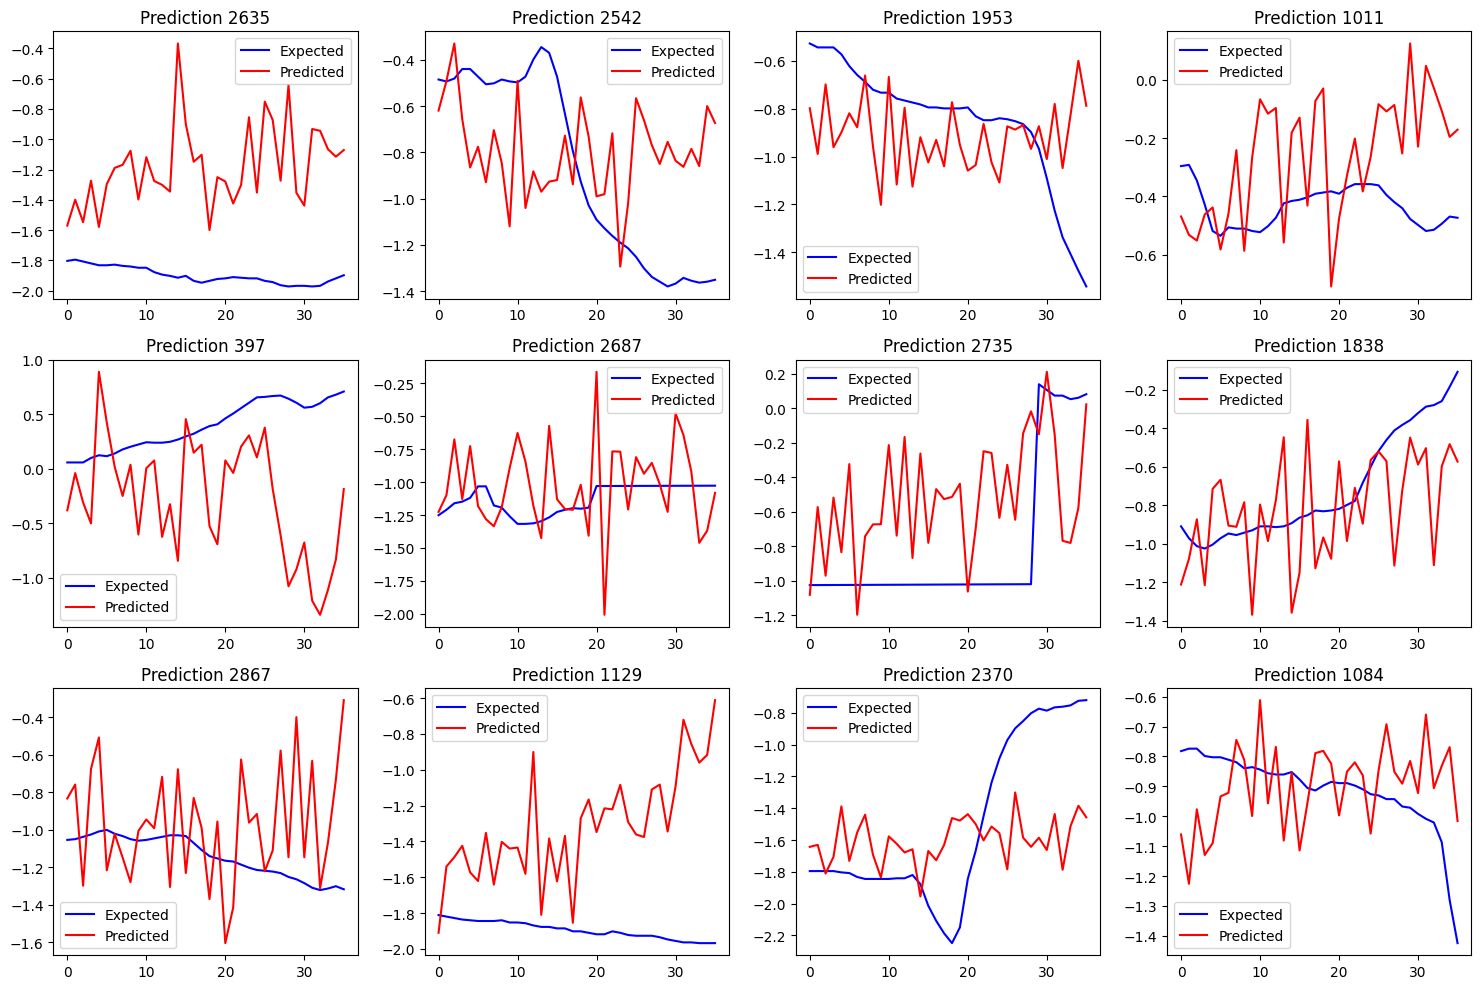

In [48]:
plot_random_predictions(model1, test_dataset, N=12, COLS=4)